In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, LabelEncoder
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', None)


In [2]:
train_df = pd.read_csv('./EIM_Train.csv')
train_df.drop(['ticker'], axis=1,inplace=True)
test_df = pd.read_csv('./EIM_test_reg.csv')
test_df.drop(['ticker'], axis=1,inplace=True)

In [3]:
def drop_columns_with_nulls_over_threshold(df, threshold=50.0):
    """
    Drop columns from the DataFrame where the percentage of NaN values is greater than the specified threshold.

    Parameters:
    df (DataFrame): The input DataFrame.
    threshold (float): The threshold percentage of NaN values to drop the columns.

    Returns:
    DataFrame: A DataFrame with the specified columns dropped.
    list: A list of columns that were dropped.
    """
    # Calculate the number of NaNs and the percentage for each column
    col_na = df.isnull().sum()
    percent = (col_na / len(df)) * 100

    # Create a DataFrame with the counts and percentages
    missing_data = pd.concat([col_na, percent], axis=1, keys=['Total', 'Percent'])

    # Find columns where the percentage of NaNs is greater than the threshold
    cols_to_drop = missing_data[missing_data['Percent'] > threshold].index

    # Drop these columns
    df_dropped = df.drop(columns=cols_to_drop)

    # Return the DataFrame with the columns dropped and the list of dropped columns
    return df_dropped, cols_to_drop


In [4]:
dropped_train_df, columns_to_drop = drop_columns_with_nulls_over_threshold(train_df)

In [5]:
dropped_test_df = test_df.drop(columns=columns_to_drop, axis=True)


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder

# Combine 'ticker' and 'category' data for both training and test data
combined_category_data = pd.concat([dropped_train_df[['category', 'long_term_projected_earnings_growth']], dropped_test_df[['category']]], axis=0)

# Get sorted unique categories based on mean 'rating'
category_mean_ratings = combined_category_data.groupby('category')['long_term_projected_earnings_growth'].mean().sort_values(ascending=True).index.tolist()

# Add a catch-all category for unknown values
category_mean_ratings = [np.nan] + category_mean_ratings


# Encode 'category' based on sorted unique categories for both training and test data
category_enc = OrdinalEncoder(categories=[category_mean_ratings])
combined_category_data_encoded = category_enc.fit_transform(combined_category_data[['category']].values)

# Update the original DataFrames in both training and test data with the encoded values
dropped_train_df['category'] = combined_category_data_encoded[:len(dropped_train_df)]
dropped_test_df['category'] = combined_category_data_encoded[len(dropped_train_df):]


In [7]:
# Possible to rearrange
equity_style_group = [np.nan] + dropped_train_df.groupby(by='equity_style')['long_term_projected_earnings_growth'].mean().sort_values(ascending=True).index.tolist()
equity_size_group = [np.nan] + dropped_train_df.groupby(by='equity_size')['long_term_projected_earnings_growth'].mean().sort_values(ascending=True).index.tolist()
nav_per_share_currency_group = [np.nan] + dropped_train_df.groupby(by='nav_per_share_currency')['long_term_projected_earnings_growth'].mean().sort_values(ascending=True).index.tolist()
shareclass_size_currency_group = [np.nan] + dropped_train_df.groupby(by='shareclass_size_currency')['long_term_projected_earnings_growth'].mean().sort_values(ascending=True).index.tolist()
fund_size_currency_group = [np.nan] + dropped_train_df.groupby(by='fund_size_currency')['long_term_projected_earnings_growth'].mean().sort_values(ascending=True).index.tolist()

column_to_encode = ['equity_style','equity_size', 'nav_per_share_currency', 'shareclass_size_currency', 'fund_size_currency']

enc = OrdinalEncoder(categories=[equity_style_group, equity_size_group, nav_per_share_currency_group, shareclass_size_currency_group, fund_size_currency_group])
dropped_train_df[column_to_encode] = enc.fit_transform(dropped_train_df[column_to_encode])
dropped_test_df[column_to_encode] = enc.transform(dropped_test_df[column_to_encode])


In [8]:
dropped_train_df.shape

(22420, 99)

In [9]:
from sklearn.impute import KNNImputer

# Exclude columns related to "C02 Emission" from the imputation process
columns_to_exclude = ['long_term_projected_earnings_growth']  # Add the actual column names you want to exclude

# Create a KNNImputer with 5 neighbors
imputer = KNNImputer(n_neighbors=5)

# Filter the columns to exclude from the imputation
columns_for_imputation = [col for col in dropped_train_df.columns if col not in columns_to_exclude]

# Fit and transform the DataFrame
ready_df_imputed = dropped_train_df.copy()
ready_df_imputed[columns_for_imputation] = imputer.fit_transform(dropped_train_df[columns_for_imputation])

# Convert the NumPy array back to a pandas DataFrame with the original column names
ready_df_imputed = pd.DataFrame(ready_df_imputed, columns=dropped_train_df.columns)

# Fit and transform the DataFrame
test_df_imputed = dropped_test_df.copy()
test_df_imputed[columns_for_imputation] = imputer.transform(dropped_test_df[columns_for_imputation])

# Convert the NumPy array back to a pandas DataFrame with the original column names
test_df_imputed = pd.DataFrame(test_df_imputed, columns=dropped_test_df.columns)

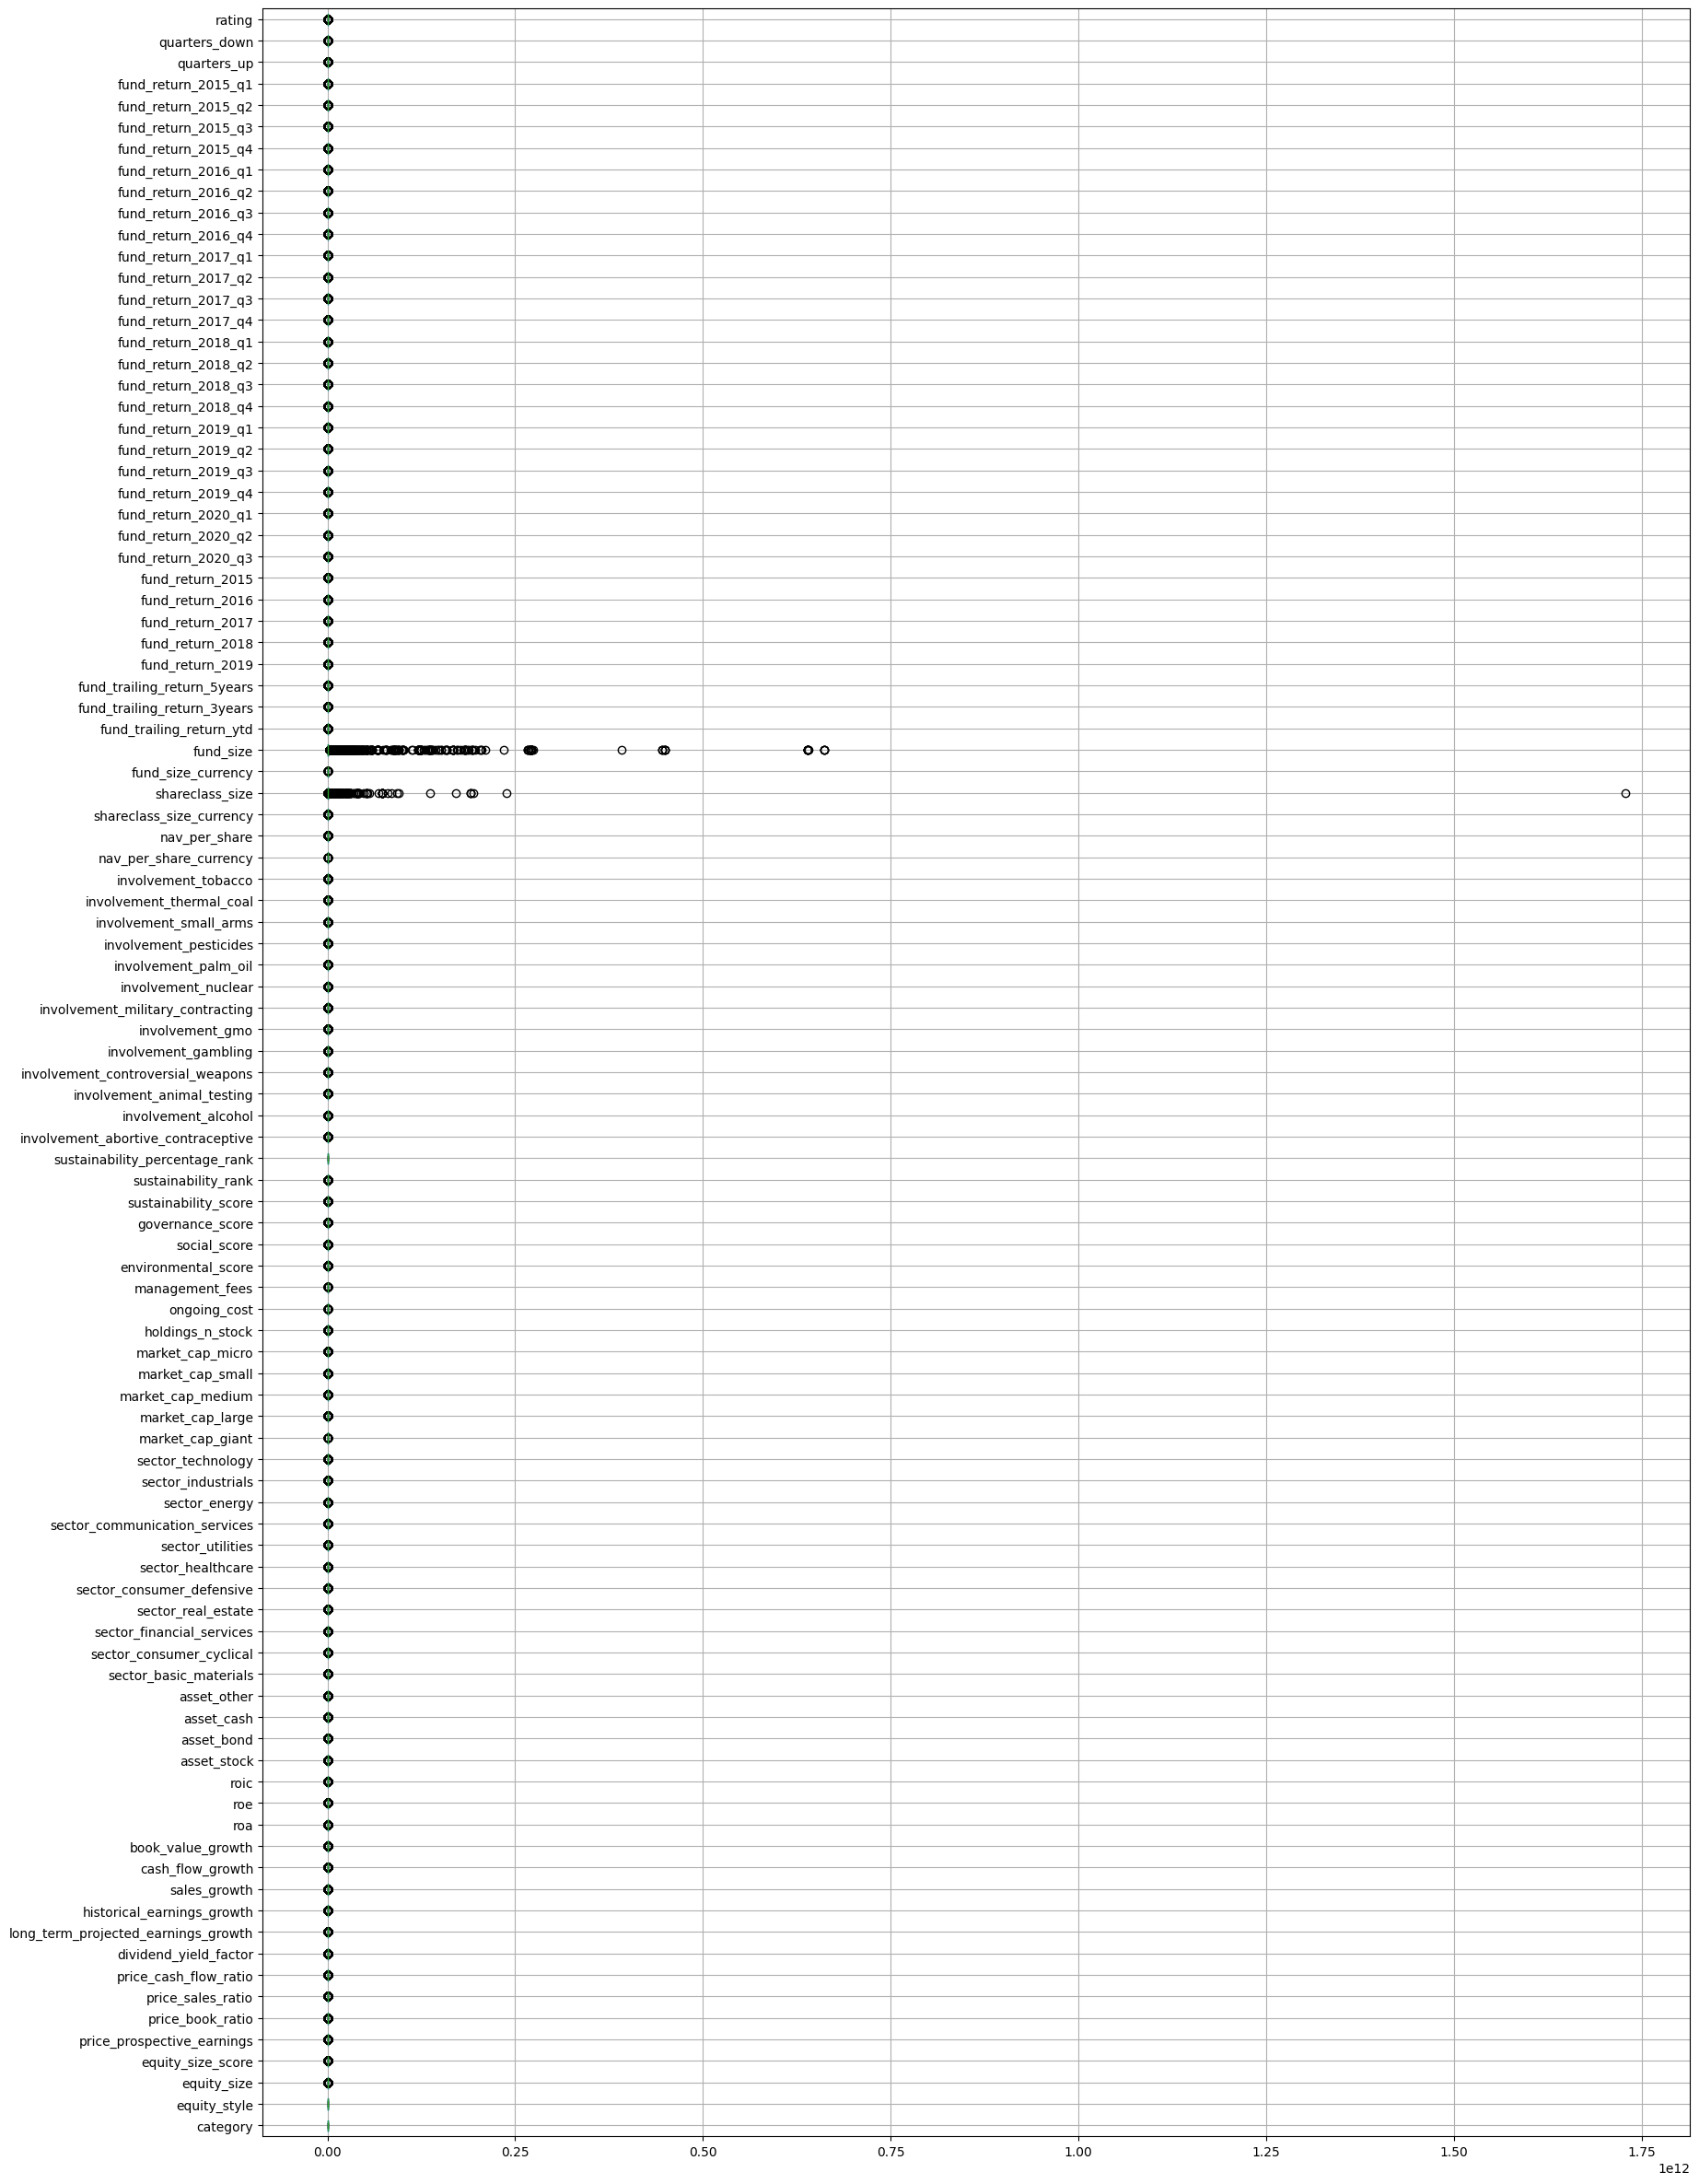

In [10]:
ready_df_imputed.boxplot(vert=False, figsize=(20,30))
plt.show()

In [11]:
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remove rows with outliers
    df_cleaned = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    return df_cleaned

In [18]:
ready_df_imputed = remove_outliers(ready_df_imputed, 'shareclass_size')

In [19]:
ready_df_imputed = remove_outliers(ready_df_imputed, 'fund_size')

In [ ]:
'nav_per_share_currency', 'shareclass_size_currency', 'fund_size_currency'

In [47]:
ready_df = pd.get_dummies(ready_df_imputed, columns=['category'], prefix='category')
test_df = pd.get_dummies(test_df_imputed, columns=['category'], prefix='category')

ready_df = pd.get_dummies(ready_df, columns=['equity_size'], prefix='equity_size')
test_df = pd.get_dummies(test_df, columns=['equity_size'], prefix='equity_size')

ready_df = pd.get_dummies(ready_df, columns=['equity_style'], prefix='equity_style')
test_df = pd.get_dummies(test_df, columns=['equity_style'], prefix='equity_style')

ready_df = pd.get_dummies(ready_df, columns=['nav_per_share_currency'], prefix='nav_per_share_currency')
test_df = pd.get_dummies(test_df, columns=['nav_per_share_currency'], prefix='nav_per_share_currency')

ready_df = pd.get_dummies(ready_df, columns=['shareclass_size_currency'], prefix='shareclass_size_currency')
test_df = pd.get_dummies(test_df, columns=['shareclass_size_currency'], prefix='shareclass_size_currency')

ready_df = pd.get_dummies(ready_df, columns=['fund_size_currency'], prefix='fund_size_currency')
test_df = pd.get_dummies(test_df, columns=['fund_size_currency'], prefix='fund_size_currency')

# Deal with test data where the value not in train
missing_cols = list(set(ready_df.columns) - set(test_df.columns))



for cols in missing_cols:
    test_df[missing_cols] = 0
    
# Ensure the order of columns in test_df is the same as ready_df
test_df = test_df[ready_df.columns]
test_df = test_df.drop(['long_term_projected_earnings_growth'], axis=1)
    
y = ready_df['long_term_projected_earnings_growth']
X = ready_df.drop(['long_term_projected_earnings_growth'], axis=1)


scaler = StandardScaler()

X = scaler.fit_transform(X)
X_final = scaler.transform(test_df)

In [48]:
X.shape

(13699, 335)

In [49]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [60]:
xgb_params = {
    'n_estimators': 3000,        # Number of boosting rounds (trees)
    'learning_rate': 0.1,      # Step size shrinkage used in update to prevent overfitting
    'max_depth': 3,            # Maximum depth of the individual trees
    'min_child_weight': 1,     # Minimum sum of instance weight (hessian) needed in a child
    'gamma': 0,                # Minimum loss reduction required to make a further partition on a leaf node
    'subsample': 1.0,          # Fraction of samples used for fitting the trees (1.0 means using all samples)
    'colsample_bytree': 1.0,   # Fraction of features used for fitting the trees (1.0 means using all features)
    'objective': 'reg:squarederror',  # Objective function for regression tasks
    'eval_metric': 'rmse',     # Evaluation metric for regression tasks
    'random_state': 42         # Random seed for reproducibility
}

In [62]:
xgb_regressor = XGBRegressor(**xgb_params)

# Fit the XGBRegressor model on the training data
xgb_regressor.fit(X_train, y_train)

# Make predictions on the test data
xgb_reg_result = xgb_regressor.predict(X_test)

In [63]:
from numpy import mean
from sklearn.model_selection import cross_val_score

print(mean(cross_val_score(xgb_regressor, X_train, y_train, cv=5)))

0.9225594176886547


In [53]:
xgb_regressor_submission = XGBRegressor(**xgb_params)

# Fit the XGBRegressor model on the training data
xgb_regressor_submission.fit(X, y)

# Make predictions on the test data
xgb_reg_result_submission = xgb_regressor_submission.predict(X_final)

In [55]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(xgb_reg_result, X_train, y_train, cv=5)  # 5-fold cross-validation as an example


InvalidParameterError: The 'estimator' parameter of check_scoring must be an object implementing 'fit'. Got 14848    16.57
9305      8.54
2662      9.00
22329    12.87
20744    10.44
11869     8.65
7013      6.55
6273     14.56
13860    13.46
8139      7.77
17721    12.60
14265    12.98
8561      8.51
10328    11.08
10506     9.77
13532     8.45
3718      8.95
15473     7.78
20973    15.49
7696      8.75
10291     9.29
4538      8.97
6718     11.43
5673     18.69
4209      9.52
22336     6.75
2199      9.39
21180    23.64
15282     6.71
5846      9.68
172       9.16
3336      8.66
12077     9.49
15853     7.59
2865      7.90
13550    13.39
2948     12.22
20284    11.61
7669      7.69
8142     10.40
10789    12.18
17613     7.59
5533      9.24
15888    10.57
8253     10.32
17493    10.04
11745     8.94
1705      8.64
16739     9.42
1256      6.16
14218    10.67
13531     7.66
15246     6.93
19922     7.63
2105      5.91
820      10.09
7564      8.12
14743     9.59
12342    12.12
8446     12.64
22073     7.64
19395    13.29
18555     9.35
6319     11.05
3656      7.86
12555     6.46
2754     10.80
10191     9.58
11913     4.70
13854    12.36
891      10.66
16554    14.79
2555      8.87
1024     12.69
12393    15.60
13415     9.78
774       8.05
17682     9.71
16357     9.95
18760    11.77
20054    26.89
11202    11.82
2759      5.32
15265     9.84
3798     15.12
607       5.26
16604    12.71
1734      9.75
5827      8.99
1259      8.33
1456      8.56
20321    10.77
20759    11.99
17017     7.34
16180    10.28
7453     11.58
21810     6.86
10777    23.64
9255     10.58
20527     7.67
5163      7.66
8698      8.02
10446    11.37
18772    13.81
18348    10.82
15224     9.18
15723     9.93
11953    11.21
305      11.30
4939      7.16
7065      9.77
4971      7.38
14531     8.14
12401    13.18
21008    11.75
19770     7.91
15477    17.62
17711     6.73
14809    11.53
17309     5.84
3826     10.00
6887      6.61
8925     10.82
20574     9.99
10572     7.27
169      13.52
2810     11.17
15630     9.29
9060      8.43
5011     11.14
2185      9.09
18072    17.28
16500    11.54
14273    41.22
5812     17.70
3671     11.53
13985     8.24
13345     8.78
13178    10.09
5129     11.67
17607     7.77
13455     7.18
14589     6.84
15761    12.13
776       9.10
12539     6.88
14936    10.67
6441     19.42
20011    12.32
21948     4.33
15945     7.64
4969     10.23
3616      8.87
18014     5.74
287       6.48
6969      9.32
11617    10.02
3179     11.68
20711     8.20
21097    12.83
14728     7.16
2031      8.45
8083      8.93
19052     9.49
17796     6.83
6800     14.84
17559    18.98
19277     7.40
14618     8.98
6603      8.63
10244     7.62
5488      5.39
11521     8.11
6539     10.72
5396     11.20
7412      9.75
2480     11.91
22232     8.35
13800     8.37
14559     8.68
3698      6.84
1818      9.87
13817    14.66
4654     12.59
14340    12.10
17199     5.81
5605      5.88
5427     12.03
13322     8.44
2210      9.01
6953      6.19
16715     4.32
15379     7.63
2483      5.94
11731    12.78
16170    13.16
12186     9.39
22179    12.92
1648      9.50
18538     7.47
12947     9.45
13248     9.17
3243     10.21
3389     13.26
7921      6.51
16365    10.73
10783     9.78
12416     5.09
8491     10.31
20681     6.48
19960    11.75
7560     11.58
5160     13.51
11070     7.05
4732      9.07
9388     10.37
11645     5.54
17417     7.48
4319     15.19
1334     10.98
20631     8.51
11581     7.66
11716     9.54
10162    11.16
19501    10.91
22023    20.11
6145      8.74
7253      9.34
20482     8.40
6588      8.36
18337    11.63
300      13.99
15909    11.13
17865     5.87
288       7.79
8895      1.00
6777      6.28
2278     13.87
19161    12.18
9097      5.91
16895     7.40
18980     9.62
2090      7.49
13538    10.47
16091     4.95
12532     9.99
9698      7.31
17691    12.16
104      10.87
906       8.79
11986    10.29
1529     10.85
15321     8.69
16481     8.41
13572     9.84
9609      8.75
2044      7.89
15362    13.68
11815     9.46
620      11.85
19965    10.90
9339     13.02
8741      9.43
17858    10.82
3522      9.85
18965     8.06
15855     5.86
16584     9.95
19306    13.57
5252     10.37
10751     7.27
20836     7.17
18692     5.32
5692      9.89
16292    17.59
4262      9.43
2884     13.16
20381     7.46
16143    10.04
2270     10.91
9031     10.76
15921     9.11
5887      7.28
4614      6.61
15375     9.77
3295      8.78
14384    11.19
5976     15.98
10262    13.30
6117      8.70
22354     5.95
16192     7.90
6299      6.88
9206      8.87
22339     7.71
17259     5.20
17051    11.42
9661     10.80
6755      8.41
11582    14.39
13008     8.81
1678     10.73
16418     6.56
5771      9.55
5993      8.27
1466     11.43
7432      7.19
11791     9.75
17014     8.70
20702    10.79
13660     7.18
21248     9.23
16312     6.46
3322      9.42
17188    13.95
5435      8.52
10153     4.23
7578     16.76
8537      9.18
13013     6.27
12722     8.16
19418    13.66
18324     6.16
15276     8.98
696       7.40
12494     7.72
2697      7.33
12188     6.87
9536      7.41
20919     7.65
10347     6.45
14949    12.59
22078    11.77
17736     7.91
19746    11.16
8133     10.57
16060     5.83
10279     7.51
5792     10.49
9287      8.58
11205    12.34
3479      6.52
17010     7.35
9693      5.42
8460      7.98
9670      7.55
17903     9.47
11285    12.30
14672     9.30
6765      8.52
15230    10.53
4604     11.04
9762      7.99
7143      9.59
11984    10.04
6605      7.09
18067     9.13
5577      7.39
2687      7.97
14322    18.05
4566      7.10
15040    16.34
7425      9.11
13946     7.11
17771    10.96
11002     8.83
17181    11.50
18693     8.86
6011      6.42
4880     12.50
10045    12.91
2247     13.85
21152    12.11
8171     10.12
3870      8.36
9989     10.93
11558     9.70
8641      9.79
8493     17.29
21124     7.83
681       8.57
16531    11.09
6934      7.01
14462    10.32
1865      9.20
16196     9.39
16071    25.66
1814      6.61
2280      8.60
16255     9.90
14612     9.91
21063     8.94
7108     12.32
6943     10.85
2692      7.32
2747      9.55
8762     12.53
15726     6.27
17087    10.09
21887    12.11
1018      8.88
10534     7.38
22095    10.07
3928      9.32
8684      9.63
9368      9.27
4338      8.54
8015      6.26
9937      6.54
18078     8.58
4314     10.96
13729     7.28
21441     9.55
20501     7.63
13312    11.24
7141     11.20
8244      8.57
17460    10.08
21132     6.20
22266    10.42
17054     9.49
5228     11.72
4726      8.34
15889     9.15
660       9.21
12701     7.34
7655     10.74
21242    10.37
9282      9.53
19772     8.98
762      12.11
19296    10.95
2330     14.41
2381     11.09
4075      8.78
2519      9.73
3460      8.70
979       7.71
13787     7.69
9034     11.47
9756     13.71
3986      8.39
17627     6.96
21268    14.56
6595     11.14
6618      9.82
17143     9.92
20431     9.91
17688     9.87
6103      8.83
2790      9.16
16120    11.53
21427     9.39
7618     12.35
5009      8.93
19554     8.92
19666    14.06
7159      7.80
3227      9.03
6961      6.89
6569      8.64
21717     4.20
12356    10.80
18849    11.26
5623      7.88
15523     8.86
5837      9.70
14005     5.04
21762    42.81
17965     6.52
17843    11.12
18351     7.56
20666    10.06
6262      6.02
14        8.78
13991     7.90
20313     9.58
11143     7.05
9858      8.27
8971      7.92
18642     7.83
4161     13.52
16695     8.58
17238     8.76
4021     13.67
2213     11.45
21813     8.15
18365    17.31
7656     11.72
13196    10.38
19491    13.95
16244    10.16
17755     8.14
8976      8.27
20203     9.99
19785     8.45
20737     8.94
6883     16.67
20888     5.71
14919    10.05
22189    15.52
9203     10.32
4837     12.90
8143      6.35
5196      5.48
14402     8.29
15083     8.35
5017      4.92
12778    10.13
14704     7.86
10517     9.52
5844     19.42
1043      9.24
20612    14.67
1364     10.69
16640     9.27
20590    10.88
10744     7.66
6424     12.21
14982     9.02
13975    13.67
11106    15.32
5941     10.64
2763      7.28
20172     9.32
6495     13.18
4072      8.74
5779     11.95
11831    11.13
18438     9.20
2974      8.30
523      10.68
16879    11.82
535      12.45
14387     8.63
614      10.03
17193    10.00
4822      9.17
1856     32.81
6425      5.55
7170      9.34
6678     10.22
7894     14.63
14020     5.04
16663    10.67
9329      6.22
6519      9.69
10138     9.31
17879     9.54
21416     5.23
10631    10.94
22111    14.79
17305     9.66
1296      8.42
4041      9.82
21024    13.75
420       9.99
7798     11.69
3829      7.90
6216      3.63
3264     10.54
12723     8.58
9931      9.03
8184      6.95
2816     11.83
866       8.50
114       8.03
15688     8.66
11267    12.29
16343    16.83
7983     12.59
19072     8.75
20507     5.70
16747     7.89
14853     7.72
21698     7.95
5820     12.54
2027      9.76
18909     9.96
6392     21.81
2526      5.70
7330     11.67
20603     9.05
10234    11.46
7913     10.66
15221     7.52
20137    11.79
9120      9.77
14688    10.24
20398     9.30
21200     7.22
8888      6.84
6554      6.26
21491    12.72
15226    15.98
6810      8.71
3578     12.37
10752    10.22
17330    10.49
5341      8.99
19982    10.15
2834     11.11
5298     10.31
19274     4.27
2799      8.58
16183    11.01
362       8.75
6703     11.53
5622     13.71
14639     7.85
18466    10.89
18409     9.44
14645     7.66
3860      7.73
7791      9.45
20038     6.54
20329    11.57
14459     8.97
19304     8.77
312      11.26
18769     5.14
16486    13.87
2560     10.85
5115      7.21
8841      9.26
21850     5.38
9647      8.82
7257     10.68
15802    10.30
1992     12.18
6071     18.31
5190      9.26
994       8.98
14252    16.21
363       7.04
2791      9.77
12134     8.94
8570      7.88
20008     5.94
10176     9.23
17581    14.96
15283     5.42
19380     4.41
7946      9.42
3956     10.40
19244     8.45
11633    11.80
5581      9.90
10592     9.77
10300     8.84
5594      8.77
21554     9.27
14624    15.53
13362    13.13
12309     9.97
14121     6.70
10746    23.02
19329     8.42
21052     8.18
5539      9.02
21777     9.68
21691     6.43
14660     7.67
15805     2.99
11417     5.42
7089      8.43
19558    14.42
2665     33.40
13286    13.36
10376     5.04
15830     9.56
5265     26.42
4966      3.13
2455     16.89
4325      5.91
7127      8.50
4900      7.98
13904     4.23
11358     6.87
785       9.33
4561     13.66
17175     9.19
10365     9.60
187      11.09
19352    11.69
2414     13.26
12806     9.95
2606     10.17
7195      8.98
4523      9.47
14307    10.65
65        9.76
9555      9.22
21910    12.97
82        8.57
6991      7.02
8135      8.24
14222     9.23
14668    10.27
14824     8.94
10526     4.99
18935    12.82
10995     7.07
12609    15.19
20443     8.03
13986    15.71
11666     9.36
2313      6.29
9133     10.47
9934      6.89
19614     6.86
8053      8.84
2966      8.40
4833     13.78
15527     9.30
16387     9.50
1957      5.35
15727     8.99
7563      7.72
5323      7.98
10841    14.67
21196    17.62
3312     10.52
15404     8.49
10864     6.98
21211     9.56
5453      6.83
3558      9.16
15753     9.17
21526     9.59
19962     9.61
1574      9.11
11273    10.80
898       4.12
12541     9.32
21470     9.14
10116     8.65
7360     11.45
16624    10.04
4806      6.32
17536     7.98
11368     7.48
14731    10.93
8907     17.84
15157     6.00
21573    11.45
16203    11.58
7477      8.24
2121      7.61
6557      9.35
15216     5.49
1527     14.83
18981    12.17
13747     8.52
14242     8.37
8688      9.36
1588      8.70
21564    11.02
12945     6.96
16981    12.88
12942     8.65
17245    10.76
18851     2.10
8757      6.31
1727      9.58
2378      7.44
649      10.30
12948    11.58
17116    17.28
20286    10.49
16205     9.35
17562     9.64
14176     7.34
17461    13.26
10235     9.44
10055     9.08
17946     3.63
6779      9.64
6293      8.89
21468     8.91
18392     9.35
1806     12.75
3521      9.71
5127      9.13
3809     19.42
17880     9.80
20560     9.54
13814    12.92
4415     10.37
5040     19.42
3533      8.81
4793      8.39
17942     6.16
8038      9.34
4381      9.38
9006      9.68
286      17.37
498      11.23
11270    12.45
11625     8.89
7657      6.46
13739    12.17
9856      9.23
7420      4.60
3044      9.07
13080     7.35
17783     8.52
1875     14.96
12561     8.84
18655     7.49
22136     9.49
6073      7.49
20613     6.84
19624     6.94
7112      7.90
19498    12.82
14006     8.64
10827    13.39
3579     10.63
13788    17.51
4165     10.54
7811      8.83
4782      8.29
1691      9.85
20061    12.77
15754     5.35
3174      6.26
11598     7.31
21832     8.91
13452     7.45
419       7.56
11404     8.86
11512     8.89
13583    12.33
2888      9.59
2654      7.66
15032    18.07
17685     9.64
18397     9.39
6881      9.32
7869     26.24
856      10.68
12817    12.92
13096     9.19
21880     8.67
10063    11.29
14935     7.91
4973     15.20
2643     14.70
8584      9.89
14606     9.19
12525     6.93
13974    11.09
22153     5.66
3481      6.51
16216     6.23
17824    10.90
17776     8.41
228      40.90
726       6.71
10719    10.46
12839     6.75
12422    10.31
22337     9.44
6886      8.30
12119    11.15
1494      7.00
5462      9.18
12097     8.49
7247      6.87
22038     7.83
14036    14.77
3241      8.75
2299      7.90
13360     8.40
21860     6.96
5519      9.24
6191      8.00
18958    11.53
3856     11.62
76        7.79
6175      8.35
6070      9.43
8794      8.30
13254    11.50
3581     11.15
21546     7.87
4318      9.66
1778      8.07
12924     9.21
12403    13.30
1908     10.30
21403     9.27
21454     9.89
2626     12.37
15063    18.18
9948      8.73
22313    12.45
6478      5.37
14487     8.58
5727      9.00
7918      8.08
12729     8.28
5479      5.32
2928     11.42
12236     9.58
12414     9.00
1700      9.64
14953     5.40
10311     8.37
1407     12.05
3439      6.81
13461    10.26
6693      7.15
1473      8.89
17541     9.87
12581     7.35
12545     8.77
2485      5.90
10742    11.16
20993     9.90
21384     4.03
7986      7.82
9800     10.20
11568     9.93
19002     7.71
12828     9.93
5426     10.24
18551    10.00
8175      8.47
492       8.69
17617     7.63
21377    15.13
5759     10.00
11790     9.11
9499      8.48
15102     7.67
9016      9.92
293      19.79
22152     8.60
3373      7.52
12322    14.56
8150      9.66
8450      8.92
6114      9.85
16215     6.75
5664      9.17
1205      8.78
5715     17.84
11080    11.45
10644     8.78
2297     12.10
3723      6.73
3415      8.27
5313      7.71
11971    16.02
5875     15.48
12519     9.71
19456     7.86
17553    15.72
14473     8.54
4284     15.20
8477      8.82
2472      9.56
20882    10.90
6102      6.59
3543      8.83
3387      9.99
16450     7.08
3821      7.91
11712     8.71
15989    10.40
10589    11.88
19355    18.74
10111     9.86
13533     7.34
12222     9.11
7988     11.92
4669      4.95
12826     8.66
17696     6.95
2242      6.14
4027      7.72
11777    17.15
15285    10.64
19814     7.16
21666    12.54
21332    17.67
5081      9.69
9599     11.37
10810     7.95
16620     9.64
15405     7.79
7737      5.97
8223      9.02
12875     8.61
19153     8.84
10642    12.33
13580     9.98
7150      7.59
6628      8.89
3371      6.96
8546      6.89
10404    13.59
18652     8.06
196      11.08
10782    18.23
12954     8.93
7571     15.04
16562    12.60
17707     6.36
8858      9.53
15663     6.82
20274     9.41
14219    14.99
17271    12.60
797      11.17
18706    17.66
16780     8.61
1750      8.27
8826      7.71
16652     7.31
16603    18.54
1107      8.08
20132     8.84
16259     3.48
17368     8.44
13227     7.38
15144     5.25
9667      6.29
4930     17.28
3210     10.66
21264     5.57
1179      9.80
15377     5.66
16534    11.26
16526    10.92
256      40.90
9689      5.65
16551     7.32
10149     7.18
4936      9.01
10092    11.92
15778    17.48
6300     19.42
14535    10.38
18744    16.17
13376    10.22
18245     7.26
9081      8.53
17082     4.50
19852     9.30
7852      5.69
3344      9.01
15386     9.23
18653     6.78
8899      4.31
17825    10.55
12079     7.63
4255      7.35
12035     8.56
19682     8.19
15654    11.53
10381     9.51
13481     8.78
17436    10.33
2885      8.75
62        7.59
16944     9.55
14825     7.96
16580     8.36
4946      5.70
12881     8.20
8111     12.11
19721     0.82
10146     6.73
1572     10.12
15725     6.69
13275     6.73
1545     22.51
21232     7.73
16990     9.69
22143     7.28
18882    10.08
9872     11.50
14475    14.77
12320     6.38
9928      7.24
17177    17.84
1283     12.41
5674      7.19
1817      9.62
15319     8.89
20340    20.87
2961     10.60
8436     13.77
13143    11.16
1649     11.83
17504    42.81
21707    10.92
87       10.99
14584     9.27
4079      9.03
7210      7.85
12773    11.53
15007     9.67
20678     8.30
14080     8.72
9997     13.30
13893     8.69
14870     7.73
21171     9.27
22331     9.30
10418     9.00
11194     9.76
8409      9.59
22171     9.31
7111      6.90
20417     8.45
11943    10.31
4340     10.11
18881    10.29
9436     16.20
678       8.30
13735    12.09
7558      8.92
9531     13.88
18883     6.22
15528    12.35
17114     9.64
8788     11.26
1578      5.70
1373      9.86
729       9.25
6726      5.40
1743      5.78
3223      7.28
17929     8.65
22367     9.31
336       9.63
16844     9.37
5076     10.52
3346      5.79
431       8.34
17451     9.66
4320      7.49
15006     5.07
13556     9.64
20036     4.46
18098     4.28
10255    11.45
16224    15.58
2470      6.90
255       8.18
21736    10.00
14481    18.23
13874     8.58
12521    10.47
20489     9.18
16639    11.15
1282     13.26
17277     5.59
19043     8.98
3822     12.23
6650      8.29
14734     8.67
2821     21.17
7424      8.26
19251     4.99
17757     5.88
21689     5.74
22416     5.04
7602      9.95
21078     9.87
141       9.78
9190      8.45
17034     8.68
14760     8.02
18724     8.61
8014     14.42
21309    10.63
723       8.63
4342      5.25
20330    10.16
14987     6.89
19353     9.54
9116      9.97
12590    17.67
18674    12.22
14098     7.15
505      10.23
14874    17.67
12530     9.13
5467      9.19
11959     5.25
1068      6.96
9208      8.47
1101      9.61
21360     9.32
8779      6.84
17007    12.32
19570    29.25
22194     9.56
4879      8.39
8056     18.18
18162    20.11
2711      8.39
9141     18.07
7931     14.92
19561     9.62
21319    10.34
18501     8.27
8008      8.73
174       8.36
14279    10.47
1931      6.69
12460     7.22
6409     10.87
13765     8.86
5338     12.50
18635     7.73
15543    10.03
1087      8.56
19616     4.00
7789     10.55
2632     13.27
10378     9.63
8299     12.32
3665      9.69
14337    10.29
9955      9.58
18759     8.61
6488      9.04
4651      8.72
6738      9.94
909       8.82
12584    10.91
20460     5.91
21398     9.72
15195     8.66
16935     8.47
19811     7.87
14364     8.84
19714    10.11
6982     10.21
1239     10.13
14434     6.52
9964      9.02
29        5.54
16600    10.24
10928     9.77
6717      8.84
15548     7.74
11668    15.02
11224    12.23
20602     7.35
14334     9.49
21847     9.49
21308     6.29
1199      8.53
9663      9.60
4440     10.98
4751     10.74
3946     13.61
4656      9.76
20947     7.41
16055    15.57
21776     7.77
1417      8.71
10749     7.86
18930     9.68
13444    11.27
10165     4.82
7879      9.99
12531     9.30
2256      9.36
11663     9.85
16276     9.84
1247      9.62
1580      7.77
1912     12.48
4005      8.08
12794    13.87
13988     8.70
4627      8.77
13161     6.86
4095      6.21
16667     7.66
2422     10.79
17470     8.15
16671     8.00
887      10.57
20674    15.19
12409     7.20
22137    11.45
4174      7.69
13219     9.89
19339     6.96
6430     11.27
20877     8.90
9333      5.68
22096     7.87
2168      8.99
11034     6.54
18031     7.82
15217     9.02
3409      8.49
19670     5.84
1521     10.20
18793    10.16
21969     8.21
1397      9.19
10350     8.73
13400     8.45
2045      5.51
3108      7.23
11024     6.52
11482     9.30
7969      8.84
7704      7.78
14423    10.95
11780     6.08
895      11.01
20186    16.63
22308     5.80
14865    11.45
10016     8.14
19482     8.54
19796     7.28
5696     10.42
18037    14.99
1961      6.71
19053     7.04
8643      8.58
18953     7.53
19707    11.03
6382     20.07
18974     7.34
4448      8.69
22104    10.37
14189    16.70
1754     12.96
12064    10.24
18405     6.65
640       8.68
12195     6.80
20958     8.33
2890      9.85
17958    13.24
13093     8.84
13539     5.66
14523     6.96
13492    10.41
16476    10.17
2551     13.15
16998     8.26
11946     9.86
9168      8.97
21493    12.52
3321      8.98
17491     8.84
4807      8.68
20539     6.46
313       6.24
22133     5.76
5438      6.72
15862     5.39
15578     3.13
12261    10.80
15474    10.90
22195     5.06
11033     6.89
19646     8.44
12000     5.87
17636     5.70
3730     16.87
2461     11.53
13480     9.32
9165      9.00
16381     8.94
2700      8.37
9769      9.13
19392     6.86
3866      9.35
19529     8.41
6046      9.96
7445      7.31
21681    11.08
11084     7.51
6087      8.68
21119     9.46
15732    10.87
12314    16.12
2058     14.56
19804     7.20
5571      7.39
14679    15.31
15960     9.30
1134      8.18
17676     9.13
8039     13.63
14363    10.80
20418     9.57
1562      8.78
5877      5.09
1967     12.67
21551     8.83
14172     7.73
366       8.84
13148     7.87
2211     14.44
17798     8.93
3844      8.63
4436     22.46
16713     8.83
11606    10.16
10523     6.59
16634     8.16
576      22.97
19322     7.62
19203     6.96
10372     8.92
14627     9.43
6297      9.99
14215     9.91
8387      9.78
22130     7.81
13770    11.53
4552     15.52
14153     9.07
11159    11.69
17158     8.18
12159     9.00
14781     8.05
6685      8.44
13069     8.64
6534      8.47
17915     7.65
21615     9.81
1212     10.21
13497    13.69
8186     10.26
6784      9.37
11029    12.02
5656     11.98
20928    17.62
13809     4.31
5742      6.35
753       8.70
5257     10.36
11572    10.63
15297     6.98
18404    10.32
13317     8.13
12830    11.28
6528      9.06
8157     15.91
3586     11.26
8568      9.77
1142      9.33
17270     7.38
17084    17.83
1478      9.15
14263     8.49
4416      8.89
12036     9.88
15904    11.09
16328     9.63
11564     7.58
13641     5.39
17332     9.17
11393    11.53
3964      9.98
15715     7.82
1553     11.80
4456      6.37
17119    16.66
10067     9.92
4420      8.58
19915    10.35
17337    12.10
21351     8.52
12022     8.21
12301    11.47
20746     4.32
14504     6.03
8831      9.76
6920     10.42
16265    13.87
10358     9.69
2061      6.78
8582      9.83
6414      4.95
171       7.26
13418     6.35
13955     8.08
10465     5.50
13936     7.76
3608     13.26
2253     11.52
1650     10.07
19929     9.26
11145     8.89
17454    10.99
2479     11.40
21221     9.39
20944     5.87
16525     9.32
20454     6.43
1926      9.33
1544     15.65
14570     8.61
6012     10.02
2205      9.57
21628    18.00
20195    12.12
9462     11.09
9848      7.34
5870      8.49
13602     7.79
5289      9.59
12495     5.00
4093     17.50
3197     13.78
6341      6.87
15783    10.15
8873      7.48
13174     8.12
15692     9.36
4608      5.51
34        8.68
3728     14.56
6669      8.87
5633      6.62
4539     10.57
12087     6.52
11643    10.17
13797     9.67
553       5.60
17971    11.14
17573     5.89
5816     10.25
2740      9.76
6836     15.53
15966     7.34
13155     0.82
4830     21.78
11045    10.57
3931      7.18
18071     6.12
11114    13.30
20983    13.14
457       7.83
21907    10.22
10539     9.77
14148     8.51
17446     9.78
10753     5.93
6127      5.80
19659     8.35
14995    15.42
803       9.02
12152    11.55
3492      9.31
6339      8.64
15558     7.92
17364     9.51
9933      6.90
21946     9.44
10911    18.80
2356     11.41
9177      5.93
6550      9.89
22328    11.14
12264     7.06
19547     8.21
10894    17.74
9503      4.82
18029    17.79
17550    17.38
10843     7.99
19206    12.23
14291     9.57
6919     13.39
2080      8.81
7864      9.56
6396      8.84
4038     11.41
6967     15.07
2671      8.30
22005     9.40
2925     10.55
3471      5.14
17459    10.66
1435      8.67
10386     7.11
8209      9.79
21471     7.41
4120     12.09
21559     8.12
16785    16.21
8905     11.57
3419     10.08
4080      5.32
14730    10.50
16954    15.31
12156     4.48
9732      9.64
12234     8.39
1632      4.32
13235     8.21
3265      9.73
15891     7.97
8742      9.25
161       6.19
18203    10.16
2991     15.07
11201     9.66
22083     9.15
13210     8.49
22235     9.65
8395     19.79
98        5.00
21828     8.92
18477     8.65
10917    15.68
17555    11.11
6347      5.70
13815    10.92
2843      8.92
3892     11.62
6972      7.74
6266      9.13
780      19.42
14035     8.86
11855     6.75
21201    16.98
16247     7.63
7952     10.19
21020     9.76
8660      7.59
20349    12.55
10837     8.94
16469     9.30
15482     9.51
680       6.94
20484    10.90
5952     13.82
15623     9.21
564       9.04
7060      6.04
1767      5.74
9970     14.66
15451     8.30
13357    12.10
5719      5.95
18770     8.88
8240      8.65
17094    11.53
10222     6.32
14985     9.67
573       9.48
8255      5.38
21898    13.30
21996     7.41
1031     12.11
2143     10.90
12966     9.59
10109     8.70
6770     10.16
28        8.49
7605      9.57
16356    13.97
7004      8.17
14403     7.41
5927     11.46
15249    11.82
4130      7.77
7070     10.09
13672     5.23
1028      8.87
5968      8.78
10582    11.08
10595     4.76
16868     9.47
6173      8.44
16204    12.20
21434     7.34
10107     9.91
10322     9.55
15943    14.42
7338      7.71
9344      4.28
2929     11.61
10871     5.72
7301      8.58
4633      7.22
7158      8.84
14777    11.15
3978      7.97
4876      7.19
7687      9.85
4380     11.81
4184      8.93
1636     12.03
17052     7.99
9676      7.99
3434     11.09
12375     7.65
12420    10.09
3259      9.10
9803      7.52
3971     10.05
20938    15.42
4624     12.85
5465      8.87
4453      9.77
6492     11.41
3800      9.62
9030      8.27
18639     5.39
9268      6.29
15898     7.92
3325     11.07
8398      8.73
17785    10.04
13664     7.31
18554     9.91
7780     11.48
15051     7.66
7792     18.23
11873     8.47
19409    13.87
1945      7.32
6378      8.04
16367    10.36
9993     13.56
10448     8.92
9121      9.77
7881      9.90
16761     7.23
16536     6.78
18095     9.39
20009     7.38
4389      9.33
5922     25.66
1860      7.07
14031     8.77
1188      4.36
4882     13.29
8918      5.22
6623      6.26
21952     6.73
20059     8.24
16369    10.81
2243     13.26
3378     11.18
9720      9.09
15863     9.41
10625     7.56
20143     9.04
2014      9.56
15607    13.12
716       9.53
930       6.24
1598      8.02
11675     6.69
13889     6.48
15382     5.74
16976    16.79
4013      7.34
20092     5.63
17213    10.66
17316     9.13
4017     10.52
12435     9.44
7550      9.38
3789     10.67
10994     8.25
17044     9.61
11657    15.40
957       6.20
15374     5.87
10543    12.10
17962     7.23
5855      7.47
7763     13.02
13687    10.41
16382     6.13
20879     7.27
13584     9.59
7398      9.50
12674     5.93
12015    28.07
19967    13.09
110      13.30
19660    10.90
3309      8.20
20144     4.32
19604    17.15
6249      8.27
20018     8.97
6032      4.69
7181      6.89
11989    10.40
18764    10.02
8797      6.68
2656      9.33
17646     7.88
17276    17.74
18671    10.04
11068     9.79
5899      8.17
6843      9.91
1225      7.34
415       5.71
4033     10.58
12104    13.53
15517    10.05
3911     13.75
11903     9.03
8362     10.85
5074     11.22
15801     9.85
5679      9.44
18504    10.59
21662     8.66
16334     5.71
1130     10.91
18581    10.67
18255     6.45
4944      8.22
12583     8.82
806       9.45
15556     6.62
8847      7.23
12174    13.65
15592    10.11
3792     10.63
9379     10.90
16548    11.54
2678     11.22
10877     7.58
11310     5.57
4925     10.00
2511     21.17
6089      7.77
2246      6.83
3349     10.53
22287    10.57
9554      9.18
4181      8.41
10458    10.87
22015     9.04
5135      6.81
6853      9.78
7842      6.52
1365      8.49
13802     8.73
20066     7.99
15010    15.87
4909      9.92
12567     5.69
17804    15.65
20073     7.38
13228    28.25
18815     7.97
14771     9.61
10813     9.77
8463      6.28
16134     9.77
2374     13.64
10316     6.26
7757      8.56
4616      7.44
3275     13.65
9364     10.53
9459      8.84
2347     10.85
188       6.59
7276     11.67
18841     9.68
11701    16.08
7488     10.28
380      13.09
10781     8.68
7935     11.55
14604    10.94
12653    13.17
15414    20.87
11332     5.71
17717     8.56
2532     11.45
18372     6.11
5483      5.14
21336     7.26
357       9.02
8862     21.76
10426     8.61
12700     9.06
11828     7.39
6580      9.25
10074     6.78
6875      6.77
1164      7.57
11410     7.31
18096     4.27
21822     8.94
15768     7.39
8263     12.13
11492     9.95
19040     8.37
16462    10.81
15172    17.37
16924    10.40
15438    10.37
17756     9.34
6188     13.59
9956      7.17
14119    11.44
5442     13.81
9316      7.43
21657     8.69
12319    17.87
6745     10.08
1232      7.27
9575     11.44
13622    10.16
19326    13.39
20621     9.30
6098      7.77
5698      8.18
19490     5.54
8714      7.75
16611    12.76
5019      7.87
11985     7.09
18936     9.10
16936     8.61
2895      8.68
2493      6.43
3224     21.36
18355     5.09
14289     9.45
4984      9.37
16647    13.54
22138     4.58
13294    10.35
58        8.22
13528     7.99
15519     9.91
4113     12.69
22180     9.32
13834    16.19
14479     7.96
8627      8.11
11243     8.37
15892     8.78
9696      9.98
5299     14.66
19767     6.87
6743      7.38
11845    11.17
14548     9.04
815       6.24
11905     6.32
11714    10.54
12037     9.06
7128      4.23
13106     4.35
13959    10.91
15570    21.73
17474     9.13
3571     11.69
22140     9.57
20839    14.67
19362     9.66
17260     7.38
17503     9.07
11364     6.44
7179      8.83
19848    15.12
4709      8.66
15744    13.99
10035     7.44
19664     5.95
9446     12.67
18832    10.40
20316     7.73
517       8.91
17772     9.15
21816     6.67
2338      9.52
2846      8.38
8663      8.07
17917     7.88
14527    17.15
22405     8.70
5643     11.83
2348     12.41
8605      6.46
841       8.84
1122      7.99
17085     6.20
22288    10.00
17545     6.37
5059     11.01
2633      9.84
19735     6.64
22072    10.58
4579     11.65
8746     10.87
4980      8.87
7649      8.13
522      13.26
15068     8.75
21826     8.55
1717      8.93
21644    10.46
6839     10.04
4410      6.89
2951      7.30
12069     8.04
21077     7.64
11782     6.46
19788    15.89
15840     8.28
16887    10.13
13615     9.64
18423     5.55
20632    13.53
18156     7.64
16235    10.71
20292     8.87
17702    10.95
10208    13.58
15764     9.96
20781    10.91
7494     15.49
5264      5.36
10050     9.14
18552    17.93
9113     12.97
4140      8.96
20250    17.91
6106     17.67
3476      4.49
14837     5.31
22286    10.16
1791      9.03
14770     9.36
929      18.39
7339     15.70
19338    10.85
9438      4.03
17438     8.66
16173    17.70
18651    11.53
11167    10.51
12869    12.48
19543     7.26
18157     7.18
8003      9.98
711      10.11
22172     8.79
6468      7.31
2489      6.38
1760      8.17
17408    10.06
21764     7.31
1444      6.93
14732     6.98
9810      7.34
20695     8.51
7559     11.04
6897      7.73
8016     11.42
10588     5.70
9063      5.80
3877      8.76
1385     10.84
2726      9.27
18855     9.52
9988     10.02
178      11.52
632       8.90
5060     10.70
18540     9.39
5891      6.89
6585     12.34
4073      9.59
5294     10.36
10068    10.14
11958    16.34
9465      4.50
18376     9.77
854       9.40
1170      7.31
16724    10.26
9922      6.87
2135      8.70
13913     9.33
6946     13.09
72        4.32
6007      7.26
13983     7.19
6399      8.54
5116      6.55
8200     10.79
11334    11.23
7730      9.62
6377      9.32
10946    10.04
14194     5.37
594      17.25
19989    11.11
18491    11.38
804       6.68
5405     14.44
14229     5.85
3635      8.88
12760    11.56
20180    12.11
16883     6.26
11538    10.08
16925    10.67
9750     14.29
1637     11.32
15460     8.91
20057     8.54
20714    10.30
20536    11.03
9373      9.99
2003      8.57
9747      8.92
68       12.37
12366     7.18
10630     8.58
9307      6.65
9135      5.40
9592      9.46
20840     9.77
7254      6.19
5939      5.56
18333     8.79
2150      8.58
21261     9.01
21682    12.13
11907     8.68
5042      7.51
2894      8.24
4791      9.00
6864      7.22
21646     7.01
10683    11.14
9918      9.11
14840     8.86
17852     7.32
3848     13.64
18934     9.09
353       8.61
3218      6.62
1098     10.16
2316      8.89
15627    10.36
21364     5.85
8374      8.55
2772      7.75
19316    13.14
17198     8.49
16305     9.14
15972     7.55
6334     10.03
6030     17.90
15200    15.53
816      11.96
1525      9.82
2870      9.61
13950     8.58
5808      9.86
16161    21.36
21143     6.49
2085      7.45
4533     10.55
13671     8.63
22285     9.03
11811     9.77
7715      5.39
21966     5.20
8821      9.47
975      10.94
18295     5.05
8793      4.36
19150    10.36
17039     3.48
1281     12.56
18289    14.10
3089      8.12
18826     9.92
19780     8.91
4042      8.37
1235      9.77
6485      8.90
15601    20.11
18632    12.16
10336    30.71
7635      9.40
11620     9.57
16890     8.69
4937      8.15
1261     10.29
12900     7.66
5450     10.96
3039      5.69
13399     7.97
2133      9.40
8499     12.88
16374     5.07
18754     5.69
18065     5.68
22314    10.25
19880     8.36
16855     9.44
5146      9.44
9353      8.26
18908     5.39
2271      7.32
1238      8.18
21749     7.28
19071    10.00
1976     11.93
20125    11.79
7987      7.35
2619      7.64
13011     7.77
16139    10.63
3491      9.38
15090     7.61
9348      8.45
3262      7.05
18596     9.17
4725      8.70
12230     8.61
17457     7.97
3377      9.37
21823     4.60
9870      8.75
20282    13.26
17533     8.34
5056      9.38
7939      9.21
18352    10.85
12067    22.26
6225      6.42
8859      9.46
4276     19.79
21072     8.66
15927    10.90
12788     9.34
942       8.64
14915     9.85
19700     8.20
1073     11.09
2769      5.93
20035    10.03
18816     9.66
13980     9.84
4998      9.01
15254    11.10
20824     9.11
21963     8.16
6288      7.87
16122     8.41
22157    10.64
14616    15.12
18875     8.48
304       9.93
18076    10.64
13063     9.41
3641     10.76
7735     10.13
3225      8.35
1771      9.59
6351      8.08
21208     8.44
2325      9.61
15088     8.28
16942    11.08
15800    12.60
18739     7.38
6394      6.72
13540     8.41
9834      9.58
17641     6.12
2021      9.87
7620      5.39
22047    13.76
3675      6.81
8650     10.31
21465     9.77
17630    17.02
7197      9.98
4976      7.38
5766      7.22
12082     7.63
5428     15.31
7263      8.44
8445      6.59
2382      8.09
22393    18.74
151       9.30
11843     9.94
10923    10.09
11755     8.51
16121     6.94
19911     9.03
13099     7.22
3953     13.02
22177     9.31
21231    10.93
13014    22.35
16746     9.31
19824    10.76
8221     10.44
4919     10.08
1815      9.70
722       9.57
11191    16.21
21997    12.90
14973     9.99
7068      5.88
5225      7.69
9024      5.23
21947     9.16
693       7.01
14539     7.31
2673      5.80
17019     6.94
21367     8.91
4722      8.55
14686    11.41
18134     9.77
13827    10.77
5583      4.76
17594    10.99
1606      6.76
7622     11.79
21630     8.12
9158      9.34
14359    11.47
17403     8.92
9043      8.38
22373     9.26
15912    10.21
10807     9.81
5960     45.55
8834      9.14
2362      9.85
20855    12.17
12007     7.99
1380      9.26
8843     10.00
15324     6.25
8467     15.12
6318      9.32
17654     8.97
18549     7.71
2146      9.91
16905     8.17
14484     8.29
13799     6.94
15899     6.20
1825      5.81
19080     6.35
119       8.43
4099      8.84
21604     9.00
14723    19.42
9261     11.41
13523     7.26
499      10.00
21550     9.26
17596    16.63
18060     6.72
3422     13.41
6189      9.27
2977      8.62
20572     8.49
16975     9.77
5305     11.52
5206     20.21
550       9.48
10331     9.61
5501     12.11
6091      9.39
16162     8.58
3015      8.98
11199     8.29
5140      7.97
247      10.41
16370    10.59
10643     9.85
17889    17.84
9424      8.78
15637     7.78
11445     6.96
3022     10.36
16630     9.34
143       9.33
4151      6.73
2034      9.59
4985     11.08
20116     6.44
20146     7.33
6769      6.29
21486     6.96
17290    10.92
4812      5.85
996      11.16
13166     9.82
4050     11.53
10964    13.95
4865      7.12
12434    10.17
21747    10.40
21044    10.54
16392     9.82
102      11.70
4975      7.01
11920     5.37
18833    12.06
18199     8.85
19937     6.52
18545     6.51
6811     12.10
10065     7.35
22227     4.83
14737    17.51
15168    10.68
13269    14.86
1618      5.93
13459    11.41
2520      8.09
3769     11.69
14756    10.87
2467      6.87
11814     8.58
6750     12.92
9778     11.19
15073     9.01
21569     7.01
14910     7.63
21310    11.94
15441    10.11
9835      9.96
18604    10.06
11820     8.83
21571     9.55
6051      8.77
18913     8.73
20976    10.29
212       9.20
8785     10.67
15012     8.79
14582    10.36
10473     9.66
15044    13.90
10967     5.23
16755     9.48
4836      6.26
480      10.47
6823      8.00
15771     7.01
2125     14.16
5097     19.42
16918     5.07
18196     6.30
10947    13.14
3135      9.93
10400    13.90
10931    11.48
22008     4.49
19655     6.70
14886    18.40
1200      7.38
15811     9.20
7125      8.84
1870      4.31
6085      6.26
7493      8.58
20503     8.54
9895     10.53
3815      8.36
20227    15.61
21387     9.23
18366     9.50
5078     61.73
12620     8.58
7405     10.64
8531      9.41
17219     8.52
4311     11.62
6564     11.45
15925    12.47
9332      8.00
3082     13.10
13334     9.32
4285      8.02
22406    10.57
5368      8.57
6231      5.89
21572    11.17
1228      5.05
7708     10.52
15011    12.17
4044     15.19
7220     10.16
6213     13.32
12009    16.38
13941    11.47
6390     10.48
16833    11.85
5071      9.94
7830      8.94
14742    11.69
21912     7.61
11286     8.99
12496     5.70
16298     7.52
22343    14.79
4568      8.35
10912     9.81
7617     13.29
20336    10.52
18454     8.60
17060     9.53
11864     6.38
5706     10.91
11239     8.75
8451     10.63
17386     7.02
7441     10.16
16378     5.59
2963      9.01
2804     13.03
21522    11.27
21797     6.42
9579      8.67
831       6.97
17000    10.22
267       3.13
13023     5.70
14474    14.77
6439     11.10
11899    17.59
12845     8.82
3758      6.42
10363    15.31
14245    14.51
1630      8.54
19861    11.35
9494     15.32
3695      5.32
14085     8.29
736      11.67
4767      9.42
13586     9.20
2682     15.19
9064      8.13
11254    11.38
12310     9.40
18942     6.72
19601    15.14
9742      7.61
1273     13.26
10610     7.17
1822     24.64
16142    17.67
5631      9.62
15340     8.51
20097    14.75
13761     9.42
10794    11.81
7612      8.50
6990     10.14
14326     8.15
7925     20.37
14684     7.38
6635     13.62
9935     11.94
20455     9.88
3104      4.20
21668     8.12
21366     9.39
11585     8.96
1871      6.05
6776      9.59
12431     8.17
13948    11.42
5915     10.00
8869     13.30
13684     9.76
5735     18.05
16172     7.81
10851    10.08
18687     8.70
2380      8.45
7837      7.13
8271      5.94
3568      7.82
18055     7.31
3442     13.54
8293      5.66
10118     7.68
5466     25.66
3195      5.88
15776     5.58
17240    12.53
20399    11.45
15175     5.87
9187      9.26
8799     13.26
10809     9.45
1276      8.84
12511     8.55
1398      9.83
5647     11.10
11309    10.29
8375     19.42
4024      8.54
5966     10.09
18464    10.69
9126     10.67
19452    15.52
16384     9.81
8651      6.16
5051      8.71
6187      6.25
6018     14.27
2425     10.29
10452     9.82
21206    15.68
16282    10.66
9608     10.16
18562    13.48
15775     9.15
4387      6.72
8770      8.84
21333    23.64
226       7.09
22118    11.19
21029    13.16
15481     6.12
5592     20.11
1346     10.47
12219    28.25
720      10.55
14135    10.40
16809    10.20
14018    12.10
18109    10.36
16313     7.44
20046     7.39
5658     14.42
2093     13.25
9397      8.91
14053    12.09
12229     8.58
14694    10.17
3817      9.78
11450     6.75
15074    11.40
18248     6.75
9824      5.88
13206     5.90
17231     7.35
15798     7.34
4471      8.24
5652     14.96
21355    10.65
10706     9.79
18239     6.91
8622     17.74
17807    11.49
15542     6.57
13632     7.52
13594     8.68
1         9.34
10166     7.71
9415     16.11
11929    15.66
4748      5.70
15848    10.64
17509    12.30
17838     9.21
19103     8.75
5791     10.29
10759     9.43
12295     8.07
20474     7.50
18413    15.85
18814     8.11
3320      8.22
11982    12.70
16546     7.71
15009    15.13
18870     8.78
20760     6.43
22184     7.26
15398     8.03
6584      8.84
12031    12.05
20419     4.80
8489     11.42
21123     9.75
7288     10.54
20491    43.54
5896     11.52
16813     6.73
361       7.98
16926     7.28
18170    17.67
5358     10.97
10390     9.77
1460      9.40
11275    10.31
78        8.54
31        9.26
15579    10.47
21943    10.03
3111     10.04
5321      9.84
14972     5.23
8404     12.11
18740    10.55
18977     9.03
21833     9.39
21624     8.21
8915      5.60
14648     9.11
Name: long_term_projected_earnings_growth, dtype: float64 instead.

In [52]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, xgb_reg_result)
mse = mean_squared_error(y_test, xgb_reg_result)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, xgb_reg_result)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2) Score: {r2}")

Mean Absolute Error (MAE): 0.42896672654848034
Mean Squared Error (MSE): 0.7003068890798123
Root Mean Squared Error (RMSE): 0.8368434077411451
R-squared (R2) Score: 0.9521328116093789


In [54]:
eim_test = pd.read_csv('EIM_test_reg.csv')

prediction_df = pd.DataFrame({
    "ticker": eim_test["ticker"],
    "long_term_projected_earnings_growth": xgb_reg_result_submission
})

prediction_df.to_csv('RegressionPrediction.csv', index=False)



In [113]:
lgbm_params = {
    'n_estimators': 2500,           # Number of boosting rounds (trees)
    'learning_rate': 0.1,         # Step size shrinkage used in update to prevent overfitting
    'max_depth': -1,              # Maximum depth of the individual trees (-1 means no limit)
    'min_child_samples': 20,      # Minimum number of data points to create a leaf
    'subsample': 1.0,            # Fraction of samples used for fitting the trees (1.0 means using all samples)
    'colsample_bytree': 1.0,      # Fraction of features used for fitting the trees (1.0 means using all features)
    'objective': 'regression',    # Objective function for regression tasks
    'metric': 'rmse',             # Evaluation metric for regression tasks
    'random_state': 42            # Random seed for reproducibility
}

In [114]:
# Initialize the LGBMRegressor with your desired parameters
lgbm_regressor = LGBMRegressor(**lgbm_params)  # Replace lgbm_params with your desired hyperparameters

# Fit the LGBMRegressor model on the training data
lgbm_regressor.fit(X_train, y_train)

# Make predictions on the test data
lgbm_reg_result = lgbm_regressor.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22296
[LightGBM] [Info] Number of data points in the train set: 13644, number of used features: 98
[LightGBM] [Info] Start training from score 10.074219


In [118]:
# Initialize the LGBMRegressor with your desired parameters
lgbm_regressor_submission = LGBMRegressor(**lgbm_params)  # Replace lgbm_params with your desired hyperparameters

# Fit the LGBMRegressor model on the training data
lgbm_regressor_submission.fit(X, y)

# Make predictions on the test data
lgbm_reg_result_submission = lgbm_regressor_submission.predict(X_final)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22324
[LightGBM] [Info] Number of data points in the train set: 17055, number of used features: 98
[LightGBM] [Info] Start training from score 10.092360


In [115]:
mae = mean_absolute_error(y_test, lgbm_reg_result)
mse = mean_squared_error(y_test, lgbm_reg_result)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, lgbm_reg_result)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2) Score: {r2}")

Mean Absolute Error (MAE): 0.29592403645597126
Mean Squared Error (MSE): 0.6625640908045025
Root Mean Squared Error (RMSE): 0.8139803995210834
R-squared (R2) Score: 0.9607898142646827


In [119]:
eim_test = pd.read_csv('EIM_test_reg.csv')

prediction_df = pd.DataFrame({
    "ticker": eim_test["ticker"],
    "long_term_projected_earnings_growth": lgbm_reg_result_submission
})

prediction_df.to_csv('RegressionLGBMPrediction.csv', index=False)

In [126]:
catboost_params = {
    'iterations': 4000,            # Number of boosting iterations (trees)
    'learning_rate': 0.1,         # Step size shrinkage used in update to prevent overfitting
    'depth': 6,                   # Maximum depth of the individual trees
    'l2_leaf_reg': 3.0,           # L2 regularization term on weights
    'bagging_temperature': 1.0,   # Controls intensity of Bayesian bagging
    'random_seed': 42,            # Random seed for reproducibility
    'loss_function': 'RMSE'       # Loss function for regression tasks (Root Mean Squared Error)
}

In [129]:
rcl_submission = CatBoostRegressor(**catboost_params)
rcl_submission.fit(X, y)
reg_result_submission = rcl_submission.predict(X_final)

0:	learn: 3.8471242	total: 42.9ms	remaining: 2m 51s
1:	learn: 3.6937653	total: 54.4ms	remaining: 1m 48s
2:	learn: 3.5596529	total: 68ms	remaining: 1m 30s
3:	learn: 3.4427432	total: 81ms	remaining: 1m 20s
4:	learn: 3.3387375	total: 92ms	remaining: 1m 13s
5:	learn: 3.2569419	total: 106ms	remaining: 1m 10s
6:	learn: 3.1660655	total: 117ms	remaining: 1m 6s
7:	learn: 3.0839971	total: 129ms	remaining: 1m 4s
8:	learn: 3.0165198	total: 140ms	remaining: 1m 2s
9:	learn: 2.9471395	total: 154ms	remaining: 1m 1s
10:	learn: 2.8878250	total: 168ms	remaining: 1m
11:	learn: 2.8440403	total: 182ms	remaining: 1m
12:	learn: 2.7961096	total: 195ms	remaining: 59.7s
13:	learn: 2.7461379	total: 207ms	remaining: 59s
14:	learn: 2.6998635	total: 218ms	remaining: 57.9s
15:	learn: 2.6667835	total: 230ms	remaining: 57.4s
16:	learn: 2.6324488	total: 241ms	remaining: 56.6s
17:	learn: 2.6008056	total: 252ms	remaining: 55.7s
18:	learn: 2.5684747	total: 263ms	remaining: 55.1s
19:	learn: 2.5390684	total: 277ms	remaining:

In [127]:
ccl = CatBoostRegressor(**catboost_params)
ccl.fit(X_train, y_train)
clas_result = ccl.predict(X_test)

0:	learn: 3.8182808	total: 30.1ms	remaining: 2m
1:	learn: 3.6760117	total: 45.8ms	remaining: 1m 31s
2:	learn: 3.5456356	total: 61.8ms	remaining: 1m 22s
3:	learn: 3.4282307	total: 76.2ms	remaining: 1m 16s
4:	learn: 3.3274623	total: 91.5ms	remaining: 1m 13s
5:	learn: 3.2474811	total: 106ms	remaining: 1m 10s
6:	learn: 3.1662572	total: 119ms	remaining: 1m 7s
7:	learn: 3.0917196	total: 135ms	remaining: 1m 7s
8:	learn: 3.0269203	total: 148ms	remaining: 1m 5s
9:	learn: 2.9675196	total: 164ms	remaining: 1m 5s
10:	learn: 2.9182715	total: 180ms	remaining: 1m 5s
11:	learn: 2.8587530	total: 199ms	remaining: 1m 6s
12:	learn: 2.8211992	total: 217ms	remaining: 1m 6s
13:	learn: 2.7825899	total: 232ms	remaining: 1m 6s
14:	learn: 2.7406364	total: 251ms	remaining: 1m 6s
15:	learn: 2.7007993	total: 266ms	remaining: 1m 6s
16:	learn: 2.6658548	total: 281ms	remaining: 1m 5s
17:	learn: 2.6252321	total: 295ms	remaining: 1m 5s
18:	learn: 2.5959076	total: 312ms	remaining: 1m 5s
19:	learn: 2.5566228	total: 327ms	

In [128]:
mae = mean_absolute_error(y_test, clas_result)
mse = mean_squared_error(y_test, clas_result)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, clas_result)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2) Score: {r2}")

Mean Absolute Error (MAE): 0.2850220612373674
Mean Squared Error (MSE): 0.545833590839139
Root Mean Squared Error (RMSE): 0.7388055162484501
R-squared (R2) Score: 0.967697862328472


In [131]:
eim_test = pd.read_csv('EIM_test_reg.csv')

prediction_df = pd.DataFrame({
    "ticker": eim_test["ticker"],
    "long_term_projected_earnings_growth": reg_result_submission
})

prediction_df.to_csv('RegressionCBPrediction.csv', index=False)



In [56]:
from sklearn.ensemble import RandomForestRegressor


rf_reg_tuned = RandomForestRegressor(min_samples_split=10, max_depth=12, criterion='squared_error')
rf_reg_tuned.fit(X_train, y_train)

rf_prediction_tuned = rf_reg_tuned.predict(X_test)

In [59]:
mae = mean_absolute_error(y_test, rf_prediction_tuned)
mse = mean_squared_error(y_test, rf_prediction_tuned)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, rf_prediction_tuned)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2) Score: {r2}")

Mean Absolute Error (MAE): 0.7641257926775149
Mean Squared Error (MSE): 1.8850612546266388
Root Mean Squared Error (RMSE): 1.3729753292126696
R-squared (R2) Score: 0.8711527994224968
